In [1]:
# 데이터 전처리
# Subword Text Encoder 사용하기
# 트랜스포머 모델 구현
# 모델 평가

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
data_path = os.path.join(os.getenv('HOME'), 'aiffel/transformer_chatbo/data/ChatbotData .csv')

In [5]:
MAX_SAMPLES = 50000

In [6]:
#전처리 함수
def preprocess_sentence(sentence):
    # 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "나는 학생입니다." => "나는 학생입니다 ."와 같이
    # 학생과 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^가-힣.?!,]', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [7]:
data =pd.read_csv(data_path)

In [8]:
#확인!

data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [11]:
#대화 가져오기 

def load_conversations(data_path, max_samples=None):
    data = pd.read_csv(data_path)
    
    inputs = []
    outputs = []
    
    for idx, row in data.iterrows():
        question = preprocess_sentence(row['Q'])
        answer = preprocess_sentence(row['A'])
        
        inputs.append(question)
        outputs.append(answer)
        
        if max_samples and len(inputs) >= max_samples:
            break
    
    return inputs, outputs

In [12]:
# 데이터 로드하고 Q, A로 저장!
questions, answers = load_conversations(data_path)
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [13]:
# 전처리 잘 되었나 확인
print('전처리 후의 50번째 질문 샘플: {}'.format(questions[49]))
print('전처리 후의 50번째 답변 샘플: {}'.format(answers[49]))

전처리 후의 50번째 질문 샘플: 감 말랭이 먹고 싶다 .
전처리 후의 50번째 답변 샘플: 맛있게 드세요 .


=> 구두점들이 단어들과 분리되어 단어와 구두점 사이에는 공백이 추가된 것을 확인할 수 있습니다. 이렇게 함으로써 단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지할 수 있습니다.

# 단어장 크기 늘림! 

- 한국어 텍스트 처리는 보통 8000~32000 사이의 크기를 사용 (일상 대화)
- 법률 문서나 의학 논문 등은 더 큰 거 (16000~50000)

In [14]:
#단어장 만들기 (각 단어에 고유한 정수 인덱스 부여)

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**14)

print(f"어휘 크기: {tokenizer.vocab_size}")

어휘 크기: 21691


### 어휘 크기 늘린 후

In [15]:
# 예시 출력, 토큰화 잘 되었나-questions
sample_string = questions[0]
tokenized_string = tokenizer.encode(sample_string)
original_string = tokenizer.decode(tokenized_string)

print(f'원본 문장: {sample_string}')
print(f'토큰화된 문장: {tokenized_string}')
print(f'디코딩된 문장: {original_string}')

# 예시 출력, 토큰화 잘 되었나-answers
sample_string = answers[0]
tokenized_string = tokenizer.encode(sample_string)
original_string = tokenizer.decode(tokenized_string)

print(f'원본 문장: {sample_string}')
print(f'토큰화된 문장: {tokenized_string}')
print(f'디코딩된 문장: {original_string}')

원본 문장: 시 땡 !
토큰화된 문장: [15418, 18414, 23]
디코딩된 문장: 시 땡 !
원본 문장: 하루가 또 가네요 .
토큰화된 문장: [2051, 45, 3891, 1]
디코딩된 문장: 하루가 또 가네요 .


### 원본 결과와 비교 

In [41]:
# 예시 출력, 토큰화 잘 되었나-questions
sample_string = questions[0]
tokenized_string = tokenizer.encode(sample_string)
original_string = tokenizer.decode(tokenized_string)

print(f'원본 문장: {sample_string}')
print(f'토큰화된 문장: {tokenized_string}')
print(f'디코딩된 문장: {original_string}')

# 예시 출력, 토큰화 잘 되었나-answers
sample_string = answers[0]
tokenized_string = tokenizer.encode(sample_string)
original_string = tokenizer.decode(tokenized_string)

print(f'원본 문장: {sample_string}')
print(f'토큰화된 문장: {tokenized_string}')
print(f'디코딩된 문장: {original_string}')

원본 문장: 시 땡 !
토큰화된 문장: [5161, 3053, 42]
디코딩된 문장: 시 땡 !
원본 문장: 하루가 또 가네요 .
토큰화된 문장: [3836, 74, 7865, 1]
디코딩된 문장: 하루가 또 가네요 .


In [16]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

#START_TOKEN은 8192, END_TOKEN은 8193의 값을 가집니다. 이는 어휘 목록의 마지막 인덱스 이후에 두 개의 새로운 토큰을 추가하는 것입니다.

### 새로 만든 토큰 번호

In [17]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [21691]
END_TOKEN의 번호 : [21692]


In [39]:
#옛날 거
#print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
#print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8132]
END_TOKEN의 번호 : [8133]


In [18]:
# start, end 추가되었으므로 vocabsize 더 커졌음을 알려주기
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

21693


In [19]:
# 패딩하기 전 max_len 구해야 함

input_lengths = [len(sentence.split()) for sentence in questions]
output_lengths = [len(sentence.split()) for sentence in answers]


In [20]:
print(f"질문 길이의 95% 백분위수: {np.percentile(input_lengths, 95)}")
print(f"답변 길이의 95% 백분위수: {np.percentile(output_lengths, 95)}")
print(f"질문 길이의 99% 백분위수: {np.percentile(input_lengths, 99)}")
print(f"답변 길이의 99% 백분위수: {np.percentile(output_lengths, 99)}")

질문 길이의 95% 백분위수: 7.0
답변 길이의 95% 백분위수: 8.0
질문 길이의 99% 백분위수: 10.0
답변 길이의 99% 백분위수: 11.0


In [21]:
#정수 인코딩 및 패딩
MAX_LENGTH = 11  #가장 높은 99% 백분위수 기준

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN  #question 각 문장들에 start, end token 붙이기
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN  #answer 문장들에 똑같이!!!

        # 최대 길이 11 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

      # 최대 길이 11으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 21693
필터링 후의 질문 샘플 개수: 11439
필터링 후의 답변 샘플 개수: 11439


# 비교
- 원래는 단어장 크기가 2**13, max_length 10으로 설정했을 때

In [46]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

#dnj

단어장의 크기 : 8134
필터링 후의 질문 샘플 개수: 9103
필터링 후의 답변 샘플 개수: 9103


In [23]:
BATCH_SIZE = 32 ##나의 작고 소중한 노트북을 위해 
BUFFER_SIZE = 9103  #데이터셋에서 셔플할 때 사용. len(샘플 수)

# 텐서를 입력으로 받아서 데이터셋 생성 (from_tensor_slices)
# dec_inputs는 answer에서 마지막 토큰을 제외 => 이전 단어 참고해서 다음 단어 에측 
# output은 답변에서 첫 번째 토큰을 제외 => 모델이 예측해야 하는 실제 정답 시퀀스, 첫부분은 아마 start token이라? 
dataset = tf.data.Dataset.from_tensor_slices((    
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()  #반복적인 데이터 로드 안하게 함 
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  #학습 수행 동안 다음 배치 미리 불러오기 

# 필요한 함수 모음

In [25]:
# 패딩 마스크, 룩어헤드 마스크 가져오기
# 패딩 마스크: 입력 시퀀스의 패딩된 부분을 마스킹해서 모델이 이를 무시하도록 함
# 룩어헤드 마스크: 디코더에서 미래 단어를 보지 못하도록 마스킹해서 시퀀스 예측을 도움

def create_padding_mask(x):  #x = 입력 시퀀스
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)  #시퀀스에서 0인 부분을 찾고 bool 반환 후, 실수 배열로 다시 반환 
    return mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, sequence length)

def create_lookahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask) 

In [26]:
#포지셔널 인코딩 
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    #어제 봤던 그 삼각함수!!!!
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], #tf.newaxis는 텐서플로 차원 확장
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],d_model=d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)
        
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]  

# 형태 요약
- query 텐서의 형태: (batch_size, num_heads, seq_len_q, depth)
- key 텐서의 형태: (batch_size, num_heads, seq_len_k, depth)
- logits 텐서의 형태: (batch_size, num_heads, seq_len_q, seq_len_k)


In [27]:
#스케일드 닷 프로덕트 어텐션

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True) #Q*K

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32) #임베딩 차원 가져오기
    logits = matmul_qk / tf.math.sqrt(depth) 

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)  #QK에 mask 있으면 뒤에 붙이기

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1) #각 쿼리 시퀀스에 대해 모든 키 시퀀스의 중요도를 확률로 변환

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output


In [29]:
# 멀티헤드 어텐션

class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0  #assert는 뒤에 쓴 게 참인지 아닌지 확인 

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)) #self.depth는 각 헤드의 차원 수, -1은 자동계산되는 시퀀스길이
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']  #다음 인코더 레이어에 나옴 
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## 머메이드로 그려 본 코드 구조

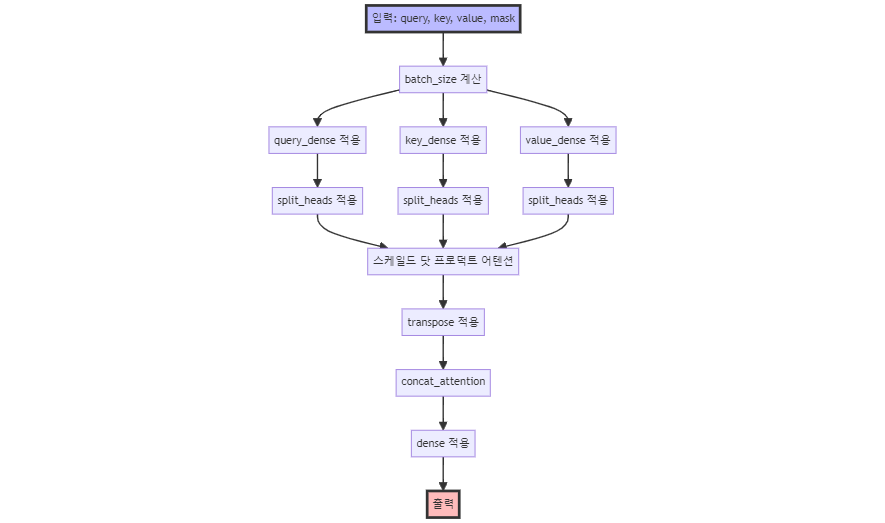

In [30]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask") #creat_padding_mask로 미리 생성됨. 
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)  #잔차 연결

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)#잔차 연결

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 "세 개"의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [34]:
#이제 트랜스포머 함수 정의!
def transformer(vocab_size,num_layers,units,d_model,num_heads,dropout,name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)  #출력 마스크 형태 지정 (batch_size, 1,1, seq_length 형태로 지정)
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_lookahead_mask,
      output_shape=(1, None, None), # 마스크 형태는 (batch_size, 1, seq_len, seq_len)
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,)(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
# 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 머메이드 다이어그램
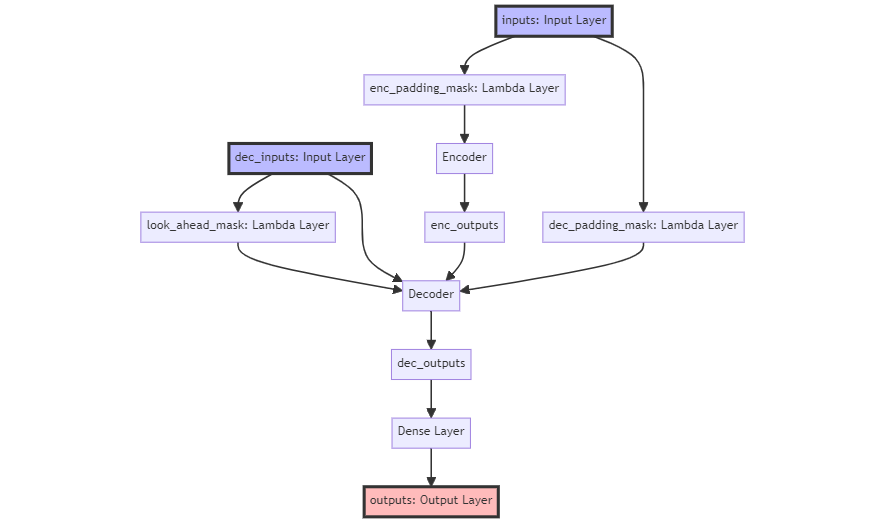

In [35]:
# 모델 생성하기

tf.keras.backend.clear_session() #현재 세션 초기화하고 메모리 해제. 모델 재정의하거나 새로 생성할 때 유용

# 하이퍼파라미터

NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율 증가시키기

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    8716032     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [36]:
# 손실함수

def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
358/358 [==============================] - 38s 62ms/step - loss: 4.6817 - accuracy: 0.0954
Epoch 2/20
358/358 [==============================] - 22s 61ms/step - loss: 3.1895 - accuracy: 0.1934
Epoch 3/20
358/358 [==============================] - 22s 61ms/step - loss: 2.9194 - accuracy: 0.1964
Epoch 4/20
358/358 [==============================] - 22s 61ms/step - loss: 2.8183 - accuracy: 0.1969
Epoch 5/20
358/358 [==============================] - 22s 61ms/step - loss: 2.7500 - accuracy: 0.1997
Epoch 6/20
358/358 [==============================] - 22s 61ms/step - loss: 2.6989 - accuracy: 0.2029
Epoch 7/20
358/358 [==============================] - 22s 61ms/step - loss: 2.6514 - accuracy: 0.2074
Epoch 8/20
358/358 [==============================] - 22s 61ms/step - loss: 2.6141 - accuracy: 0.2090
Epoch 9/20
358/358 [==============================] - 22s 61ms/step - loss: 2.5924 - accuracy: 0.2097
Epoch 10/20
358/358 [==============================] - 22s 61ms/step - loss: 2.564

In [40]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [41]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

## 20에폭


In [42]:
sentence_generation('요즘 너무 힘들어요')

입력 : 요즘 너무 힘들어요
출력 : 마음이 좀 괜찮아졌길 바랄게요 .


'마음이 좀 괜찮아졌길 바랄게요 .'

In [43]:
sentence_generation('결혼 못할거 같아요')

입력 : 결혼 못할거 같아요
출력 : 사랑은 마음이 마음이 마음이 마음이 마음이 마음이 마음이 마음이 마음이 마음이 


'사랑은 마음이 마음이 마음이 마음이 마음이 마음이 마음이 마음이 마음이 마음이 '

In [44]:
sentence_generation('어떻게 하면 남자친구가 생길까요?')

입력 : 어떻게 하면 남자친구가 생길까요?
출력 : 이제 좀 놓아주세요 .


'이제 좀 놓아주세요 .'

In [45]:
sentence_generation('점심 메뉴 추천해줘')

입력 : 점심 메뉴 추천해줘
출력 : 마음이 좀 괜찮아졌길 바랄게요 .


'마음이 좀 괜찮아졌길 바랄게요 .'

## 기존 배치_64, 인코딩 레이어 4개, 10에폭 + 40 추가

In [83]:
sentence_generation('요즘 너무 힘들어요')

입력 : 요즘 너무 힘들어요
출력 : 잠시 눈을 감고 휴식을 취해보세요 .


'잠시 눈을 감고 휴식을 취해보세요 .'

In [84]:
sentence_generation('결혼 못할거 같아요')

입력 : 결혼 못할거 같아요
출력 : 따뜻한 계획 만 해요 .


'따뜻한 계획 만 해요 .'

In [85]:
sentence_generation('어떻게 하면 남자친구가 생길까요?')

입력 : 어떻게 하면 남자친구가 생길까요?
출력 : 꾸준히 만나다보면 생길 수 있어요 .


'꾸준히 만나다보면 생길 수 있어요 .'

In [86]:
sentence_generation('점심 메뉴 추천해줘')

입력 : 점심 메뉴 추천해줘
출력 : 냉장고 파먹기 해보세요 .


'냉장고 파먹기 해보세요 .'

In [89]:
sentence_generation('포도 먹고싶어')

입력 : 포도 먹고싶어
출력 : 고백에 성별은 없어죠 .


'고백에 성별은 없어죠 .'

In [90]:
sentence_generation('마라탕 좋아해?')

입력 : 마라탕 좋아해?
출력 : 특별한 적이고 고민이 줄게요 .


'특별한 적이고 고민이 줄게요 .'

# 회고

- 챗봇은 무슨 데이터를 학습했냐에 따라 대답의 컨텐츠에 큰 영향을 받는다. 
- batch_size가 큰게 많이 중요한가보다.
